In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pomegranate as pom
import pickle

In [2]:
import import_ipynb
import readSequenceFunctions as rsf

importing Jupyter notebook from readSequenceFunctions.ipynb


In [3]:
np.set_printoptions(precision=6, linewidth=120, suppress=True)

In [4]:
seqDict,seqDictT,trainList,trainNamesList,testList,testNamesList=rsf.traindAndTestDataset(rsf.pathsBCE)

## Model

In [5]:
with open("../Pickle/model3S-best-c1.store","rb") as file:
    model=pickle.load(file)

In [6]:
model.dense_transition_matrix()

array([[0.99639 , 0.      , 0.      , 0.00361 , 0.      , 0.      ],
       [0.      , 0.993395, 0.006605, 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.994116, 0.005884, 0.      , 0.      ],
       [0.      , 0.      , 0.      , 0.      , 0.      , 1.      ],
       [0.503482, 0.496518, 0.      , 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ]])

In [8]:
model.states

[{
     "weight" : 1.0,
     "distribution" : {
         "name" : "DiscreteDistribution",
         "frozen" : false,
         "parameters" : [
             {
                 "2" : 0.11268865352843098,
                 "1" : 0.30439003076983423,
                 "0" : 0.5829213157017367,
                 "3" : 0.0
             }
         ],
         "class" : "Distribution",
         "dtype" : "int"
     },
     "name" : "s0",
     "class" : "State"
 }, {
     "weight" : 1.0,
     "distribution" : {
         "name" : "DiscreteDistribution",
         "frozen" : false,
         "parameters" : [
             {
                 "2" : 0.12809005617571378,
                 "1" : 0.203786232248274,
                 "0" : 0.6681237115760121,
                 "3" : 0.0
             }
         ],
         "class" : "Distribution",
         "dtype" : "int"
     },
     "name" : "s1",
     "class" : "State"
 }, {
     "weight" : 1.0,
     "distribution" : {
         "name" : "DiscreteDistribution"

## Histograms

In [23]:
results=[model.predict(seq, algorithm="viterbi") for seq in seqDictT.values()]

lengths=np.array([len(res) for res in results])

path=np.array([res[1] for res in results])

In [31]:
path

array([1, 1, 0, ..., 1, 1, 0])

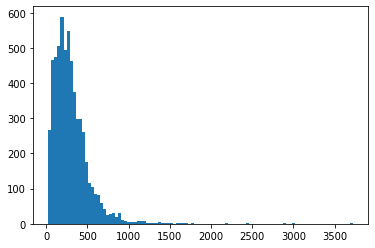

In [37]:
plt.hist(lengths, bins=100)
plt.show()

### Jednostanowe

###### Liczba sekwencji w zależności od długości

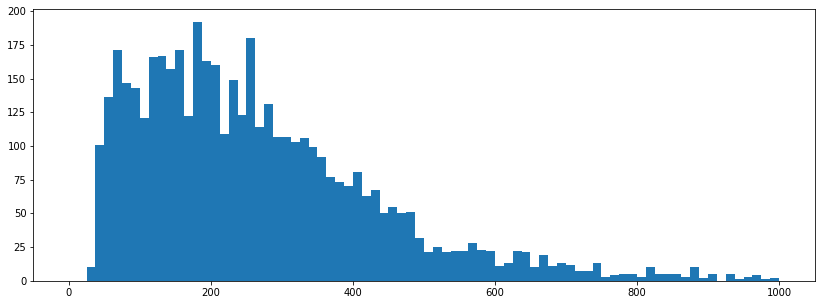

In [62]:
plt.gcf().set_size_inches(14,5)
plt.hist(lengths[path==0], bins=80, range=(0,1000))
plt.show()

### Dwustanowe

###### Liczba sekwencji w zależności od długości

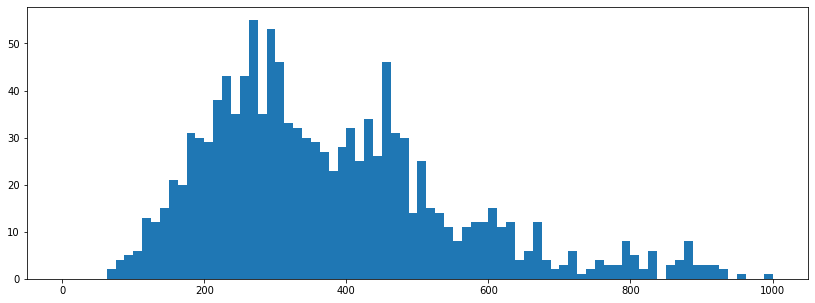

In [63]:
plt.gcf().set_size_inches(14,5)
plt.hist(lengths[path==1], bins=80, range=(0,1000))
plt.show()

###### Liczba sekwencji w zależności od udziału pierszego fragmentu

In [104]:
reg=[np.unique(np.array(res),return_counts=True) for res in results]

reg=list(filter(lambda x:x[0][0]!=0, reg))

fraq=np.array([seq[1][0]/(seq[1][1]+seq[1][0]) for seq in reg])

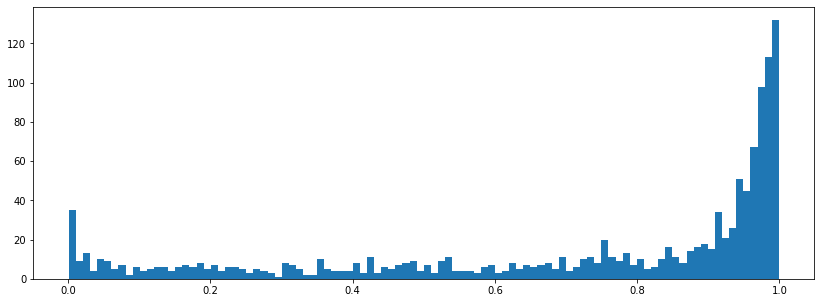

In [107]:
plt.gcf().set_size_inches(14,5)
plt.hist(fraq, bins=100)
plt.show()

## Poprawa modelu

In [131]:
b3=model.summarize(list(seqDictT.values()))
b3

-1624717.3314885849

In [110]:
def endDistr(n):
    """Crete DiscreteDistribution which generate only stop codons."""
    d={}
    for i in range(n):
        d[i]=0
    d[rsf.usedCoding.stopCodonsSymbol]=1
    return pom.DiscreteDistribution(d)

In [111]:
def randomDistr(n, generator=None):
    """Create random DiscreteDistribution, which create integers from 0 to n-1"""
    d={}
    if generator is not None:
        generatedList=generator.uniform(size=n)
    else:
        generatedList=np.random.rand(n)
    sumOfList=np.sum(generatedList)
    generatedList/=sumOfList
    for i in range(n):
        d[i]=generatedList[i]
    return pom.DiscreteDistribution(d)

In [135]:
def createModel():
    generator=np.random.default_rng(seed=20200217)
    distributionList=[randomDistr(4, generator=generator)]*6
    distributionList.append(endDistr(4))
    
    transMatrix=np.array([[1,0,0,0,0,0,1],
                          [0,1,1,0,0,0,0],
                          [0,0,1,0,0,0,1],
                          [0,0,0,1,1,0,0],
                          [0,0,0,0,1,1,0],
                          [0,0,0,0,0,1,1],
                          [0,0,0,0,0,0,0]])

    start=np.array([1,1,0,1,0,0,0])
    end=np.array([0,0,0,0,0,0,1])
    return pom.hmm.HiddenMarkovModel.from_matrix(transMatrix, distributionList,start,end)

In [122]:
M=createModel()

In [126]:
val=M.fit(list(seqDictT.values()), verbose=True, return_history=True,stop_threshold=1)

[1] Improvement: 2476845.2466698834	Time (s): 3.858
[2] Improvement: 0.8431674391031265	Time (s): 3.816
Total Training Improvement: 2476846.0898373225
Total Training Time (s): 11.7491


In [133]:
score=M.summarize(seqDictT.values())

Score rozszerzenia łańcucha 2 stanowego do trzy stanowego

In [134]:
score-b3

-3877.6158986391965

In [136]:
M=createModel()

In [137]:
val=M.fit(list(seqDictT.values()), verbose=True, return_history=True,stop_threshold=1)

[1] Improvement: 2454917.606525667	Time (s): 5.372
[2] Improvement: 2.961475868942216	Time (s): 5.39
[3] Improvement: 3.946689663687721	Time (s): 5.618
[4] Improvement: 4.937376691494137	Time (s): 5.353
[5] Improvement: 5.739607378607616	Time (s): 5.312
[6] Improvement: 6.13187252660282	Time (s): 5.287
[7] Improvement: 6.015050275251269	Time (s): 5.222
[8] Improvement: 5.500040058046579	Time (s): 5.272
[9] Improvement: 5.277132211951539	Time (s): 5.396
[10] Improvement: 50.784630361478776	Time (s): 5.497
[11] Improvement: 24.61809975723736	Time (s): 5.229
[12] Improvement: 15.136657938361168	Time (s): 5.212
[13] Improvement: 10.489824676187709	Time (s): 5.212
[14] Improvement: 7.375542865833268	Time (s): 5.221
[15] Improvement: 5.348415598273277	Time (s): 5.328
[16] Improvement: 3.9949269611388445	Time (s): 5.205
[17] Improvement: 3.058317390969023	Time (s): 5.226
[18] Improvement: 2.3885439024306834	Time (s): 5.216
[19] Improvement: 1.8961681411601603	Time (s): 5.239
[20] Improvement:

In [138]:
score=M.summarize(seqDictT.values())

In [139]:
score-b3

-3812.8496162442025

In [142]:
M.dense_transition_matrix()

array([[0.99867 , 0.      , 0.      , 0.      , 0.      , 0.      , 0.00133 , 0.      , 0.      ],
       [0.      , 0.982431, 0.017569, 0.      , 0.      , 0.      , 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.982431, 0.      , 0.      , 0.      , 0.017569, 0.      , 0.      ],
       [0.      , 0.      , 0.      , 0.990015, 0.009985, 0.      , 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , 0.      , 0.990015, 0.009985, 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , 0.      , 0.      , 0.990015, 0.009985, 0.      , 0.      ],
       [0.      , 0.      , 0.      , 0.      , 0.      , 0.      , 0.      , 0.      , 1.      ],
       [0.026203, 0.072329, 0.      , 0.901469, 0.      , 0.      , 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , 0.      , 0.      , 0.      , 0.      , 0.      , 0.      ]])